#Clasificación con Random Forest 

En este cuaderno mostramos una modelización de la diferencia de porcentaje de voto entre PSOE y PP en las elecciones generales de abril 2019. Se trata de la misma variable objetivo que en el otro cuaderno de random forest, solo que en esta ocasión utilizamos clasificación y no regresión.

El proceso es, por otra parte, el habitual seguido en otros modelos: definición de la variable objetivo, tratamiento de los datasets train y test, y modelización. En este último paso haremos una selección de características.

##Selección de la variable objetivo

Comenzamos cargando las librerías necesarias y del dataset de las elecciones de abril 2019.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str'}

In [ ]:
df_eleccion = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/gen_A19_unif_cols_prov.txt', dtype = strings)

In [ ]:
df_eleccion

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,022019041010400101001,01,04,04001,400101001,Andalucía,Almería,Abla,1014,768,0.757396,5,763,9,754,149,326,131,44,0,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,73,80,89,81,94,87,91,77,72,42,67,56,19,4,0,1249,635,614,0.269816,0.590072,0.140112,291.0,0.243986,0.232986,143.0,0.419580,0.559441,0.329493,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 149, 'PSOE': 326, 'Cs': 131, 'UP': 44, ...","[('PSOE', 326), ('PP', 149), ('Cs', 131), ('VO..."
1,022019041010400201001,01,04,04002,400201001,Andalucía,Almería,Abrucena,1039,798,0.768046,6,792,7,785,127,380,91,60,0,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,...,60,75,70,70,108,101,99,86,61,64,61,46,14,2,1,1202,637,565,0.278702,0.609817,0.111481,323.0,0.238390,0.268719,158.0,0.367089,0.601266,0.328482,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 127, 'PSOE': 380, 'Cs': 91, 'UP': 60, '...","[('PSOE', 380), ('PP', 127), ('VOX', 113), ('C..."
2,022019041010400301001,01,04,04003,400301001,Andalucía,Almería,Adra,671,519,0.773472,4,515,1,514,162,131,68,44,0,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,...,54,54,54,61,82,75,67,48,37,40,26,15,3,1,0,892,435,457,0.190583,0.643498,0.165919,7571.0,0.393871,8.487668,3036.0,0.399868,0.459157,0.286226,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 162, 'PSOE': 131, 'Cs': 68, 'UP': 44, '...","[('PP', 162), ('PSOE', 131), ('VOX', 103), ('C..."
3,022019041010400301002,01,04,04003,400301002,Andalucía,Almería,Adra,1282,954,0.744150,13,941,7,934,239,241,166,62,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,...,108,158,162,150,140,119,103,67,49,37,30,14,7,1,0,1752,865,887,0.117009,0.647260,0.235731,7571.0,0.393871,4.321347,3036.0,0.399868,0.459157,0.286226,8599.0,7941.0,25677.0,23400.0,5381.0,4837.0,1815.0,1724.0,343.0,464.0,"{'PP': 239, 'PSOE': 241, 'Cs': 166, 'UP': 62, ...","[('PSOE', 241), ('PP', 239), ('VOX', 218), ('C..."
4,022019041010400301003,01,04,04003,400301003,Andalucía,Almería,Adra,1535,1087,0.708143,20,1067,6,1061,274,252,170,67,0,282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,189,178,215,227,164,110,96,61,58,41,40,27,4,4,0,2240,1094,1146,0.104911,0.647768,0.247321,7571.0,0.393871,3.379911,3036.0,0.399868,0.459157,0.286226,8076.0,7150.0,22051.0,19687.0,5224.0,4044.0,1170.0,1198.0,416.0,476.0,"{'PP': 274, 'PSOE': 252, 'Cs': 170, 'UP': 67, ...","[('VOX', 282), ('PP', 274), ('PSOE', 252), ('C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36312,022019041195200108011,19,52,52001,5200108011,Melilla,Melilla,Melilla,1605,1118,0.696573,9,1109,4,1105,250,194,168,38,0,167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,288,...,181,185,171,164,165,180,155,97,38,34,19,16,4,3,0,2480,1244,1236,0.085081,0.623387,0.291532,24290.0,0.193413,9.794355,11827.0,0.381331,0.398326,0.327464,16433.0,15847.0,66352.0,62632.0,11378.0,11119.0,1508.0,1274.0,167.0,166.0,"{'PP': 250, 'PSOE': 194, 'Cs': 168, 'UP': 38, ...","[(

In [ ]:
df_eleccion.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Definimos la columna de diferencia de porcentaje de voto PSOE-PP, de la que deduciremos la que utilicemos en la clasificación.

In [ ]:
df_eleccion['diff PSOE-PP'] = df_eleccion['% PSOE'] - df_eleccion['% PP']

In [ ]:
df_eleccion['diff PSOE-PP'].describe()

count    36315.000000
mean         0.102604
std          0.164478
min         -1.000000
25%          0.019355
50%          0.117730
75%          0.203527
max          0.920434
Name: diff PSOE-PP, dtype: float64

In [ ]:
df_eleccion['diff PSOE-PP'].isna().sum()

2

In [ ]:
df_eleccion.loc[df_eleccion['diff PSOE-PP'].isna()]

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,diff PSOE-PP
10568,022019041063907502007,06,39,39075,3907502007,Cantabria,Cantabria,Santander,685,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,64,73,56,64,63,56,59,55,38,43,29,10,3,3,882,385,497,0.272109,0.574830,0.153061,91873.0,0.105613,104.164399,14572.0,0.452443,0.535479,0.136897,12844.0,12948.0,30563.0,30188.0,8117.0,7790.0,5171.0,5126.0,232.0,287.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0...","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),...",NaN
14870,022019041083735701001,08,37,37357,3735701001,Castilla - La Mancha,Salamanca,Villar de Ciervo,258,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11,11,10,20,26,18,13,26,24,26,29,12,3,1,277,146,131,0.483755,0.462094,0.054152,44.0,0.681818,0.158845,14.0,0.428571,0.714286,0.241379,9536.0,8848.0,18599.0,18138.0,3933.0,3281.0,5148.0,4190.0,163.0,261.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0...","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),...",NaN


Echamos un vistazo a los porcentajes de voto a ambas formacionee, y la diferencia entre ambos. Queda claro que en la mayor parte de secciones ganó el PSOE.

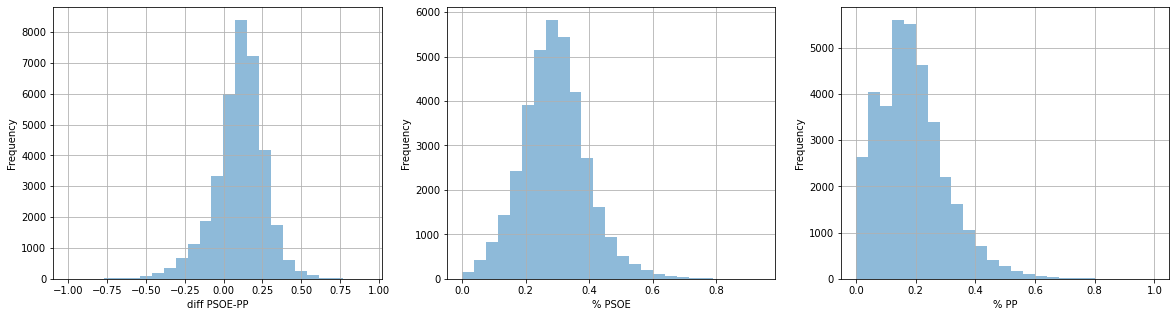

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
df_eleccion['diff PSOE-PP'].plot.hist(alpha=0.5, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('diff PSOE-PP')

plt.subplot(1,3,2)
df_eleccion['% PSOE'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PSOE')

plt.subplot(1,3,3)
df_eleccion['% PP'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PP')

plt.show()

Pretendemos distribuir la diferencia de porcentaje en cinco bins de tamaño similar, por lo que hacemos un pcut para ver por donde prodrían ir los tiros. 

In [ ]:
pd.qcut(np.array(df_eleccion['diff PSOE-PP']), 5)

[(0.225, 0.92], (0.225, 0.92], (-1.001, -0.00991], (-0.00991, 0.0841], (-1.001, -0.00991], ..., (-1.001, -0.00991], (-1.001, -0.00991], (-0.00991, 0.0841], (-1.001, -0.00991], (-1.001, -0.00991]]
Length: 36317
Categories (5, interval[float64]): [(-1.001, -0.00991] < (-0.00991, 0.0841] < (0.0841, 0.149] <
                                    (0.149, 0.225] < (0.225, 0.92]]

In [ ]:
df_eleccion['PSOE'].sum()

7481667

Definimos la función que aplicaremos para asignar los bins, denominados de 0 a 4 inclusible, y cuyos rangos hemos determinado a partir del qcut.

In [ ]:
def categoria(x):
  if x < 0:
    return '0'

  if x < 0.08:
    return '1'

  if x < 0.16:
    return '2'

  if x < 0.24:
    return '3'

  return '4'

Definimos de esta forma la columna categórica.

In [ ]:
df_eleccion['diff PSOE-PP_cat'] = ''

In [ ]:
for ind in range(len(df_eleccion['diff PSOE-PP'])):

  df_eleccion['diff PSOE-PP_cat'][ind] = categoria(df_eleccion['diff PSOE-PP'][ind])


Vemos que la columna está más o menos compensada, y que el bin mayor está justo en el centro, así que parece una buena división.

In [ ]:
df_eleccion['diff PSOE-PP_cat'].value_counts()

2    8802
0    7737
3    7176
1    6422
4    6180
Name: diff PSOE-PP_cat, dtype: int64

In [ ]:
df_eleccion.describe()

,cod_sec,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,% PP,% PSOE,% UP,% Vox,% Cs,% IU,0-4,...,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP
count,3.631700e+04,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.0,36317.000000,36317.0,36317.0,36317.0,36317.000000,36317.000000,36317.0,36317.0,36317.000000,36317.000000,36317.0,36317.000000,36317.0,36317.0,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36315.000000,36315.000000,36315.000000,36315.000000,36315.000000,36315.0,36317.000000,...,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,3.627100e+04,36271.000000,36271.000000,36303.000000,36303.000000,36303.000000,36271.000000,36178.000000,36178.000000,36178.000000,36178.000000,34041.000000,34041.000000,34041.000000,34041.000000,34041.000000,34041.000000,36315.000000
mean,2.566376e+09,958.261117,725.824903,0.758828,7.581408,718.243495,5.482749,712.760746,122.912851,206.010050,113.907674,103.239089,0.0,73.707134,0.0,0.0,0.0,27.964645,13.715533,0.0,0.0,10.867665,7.127461,0.0,3.778258,0.0,0.0,2.583170,1.436132,0.611614,4.761021,8.971886,11.166561,0.188463,0.291067,0.136721,0.102196,0.151376,0.0,56.135226,...,70.665556,78.761737,96.169838,110.514800,105.155189,100.169067,89.956467,77.074400,66.051574,59.912438,44.553212,37.277694,26.853732,11.442245,2.852851,0.448908,1294.881405,634.480491,660.400914,0.222335,0.600481,0.177183,2.150336e+05,0.230943,173.219401,28027.931493,0.428061,0.528475,0.210434,11505.018739,10869.106348,29477.534003,28020.872928,8314.100367,7306.835867,3178.389679,2940.963073,289.498314,346.348407,0.102604
std,1.436807e+09,437.906979,344.834412,0.073586,6.115915,341.724321,4.412176,339.188435,87.894068,112.301806,82.379609,68.731923,0.0,59.657869,0.0,0.0,0.0,82.872402,46.136236,0.0,0.0,55.301269,36.134619,0.0,24.598082,0.0,0.0,12.183276,14.238636,6.648651,19.875036,7.112796,18.314118,0.114328,0.102823,0.061077,0.060154,0.065176,0.0,45.273236,...,41.224067,49.876737,66.621546,75.273439,65.453286,55.428526,46.961287,41.709315,38.432323,36.645395,26.556226,21.207614,16.397375,8.493468,2.887382,0.832193,653.478204,326.033879,330.748408,0.095902,0.054204,0.060463,5.192026e+05,0.157414,446.946651,56141.160612,0.091417,0.097089,0.103300,3650.026093,3530.809436,10092.134163,9698.750682,3576.994175,3383.289953,1401.570239,1250.000095,119.816182,118.278271,0.164478
min,1.001010e+08,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.00

##Dataset de Train

Ya podemos pasar al tratamiento de los datasets de train y test, que hallamos y nos quedamos con el de train.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_eleccion, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/train_set_RF_dif_PP_PSOE.txt', index=False)
test.to_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/test_set_RF_dif_PP_PSOE.txt', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/train_set_RF_dif_PP_PSOE.txt',  dtype = strings)

Dimensiones del dataset de training: (29053, 99)
Dimensiones del dataset de test: (7264, 99)


In [ ]:
df_train

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,diff PSOE-PP,diff PSOE-PP_cat
0,022019041113605701001,11,36,36057,3605701001,Extremadura,Pontevedra,Vigo,790,607,0.768354,11,596,4,592,95,230,72,135,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,13,3,...,83,83,73,62,56,56,86,43,40,33,12,3,0,1037,485,552,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,9681.0,24932.0,23853.0,6997.0,5506.0,3853.0,4029.0,325.0,399.0,"{'PP': 95, 'PSOE': 230, 'Cs': 72, 'UP': 135, '...","[('PSOE', 230), ('UP', 135), ('PP', 95), ('Cs'...",0.226510,3
1,022019041122801303008,12,28,28013,2801303008,Galicia,Madrid,Aranjuez,1237,878,0.709782,8,870,13,857,135,238,181,143,0,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,13,...,84,128,154,114,112,60,51,37,48,66,43,17,3,1502,699,803,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,11003.0,38245.0,36290.0,11471.0,9729.0,2131.0,1914.0,243.0,281.0,"{'PP': 135, 'PSOE': 238, 'Cs': 181, 'UP': 143,...","[('PSOE', 238), ('Cs', 181), ('UP', 143), ('PP...",0.118391,2
2,022019041071910301001,07,19,19103,1910301001,Castilla y León,Guadalajara,Checa,251,218,0.868526,2,216,1,215,65,90,19,12,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,18,16,19,33,19,20,16,17,18,17,9,1,0,282,172,110,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,10383.0,23170.0,20407.0,9044.0,6751.0,3908.0,3371.0,176.0,230.0,"{'PP': 65, 'PSOE': 90, 'Cs': 19, 'UP': 12, 'IU...","[('PSOE', 90), ('PP', 65), ('VOX', 28), ('Cs',...",0.115741,2
3,022019041100601201002,10,06,06012,601201002,C. Valenciana,Badajoz,Arroyo de San Serván,1011,794,0.785361,7,787,4,783,122,431,81,60,0,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,...,76,67,101,101,73,51,60,56,38,34,9,5,0,1237,629,608,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,6773.0,17583.0,17611.0,3733.0,2949.0,1957.0,2096.0,719.0,670.0,"{'PP': 122, 'PSOE': 431, 'Cs': 81, 'UP': 60, '...","[('PSOE', 431), ('PP', 122), ('VOX', 82), ('Cs...",0.392630,4
4,022019041011400501003,01,14,14005,1400501003,Andalucía,Córdoba,Almodóvar del Río,758,543,0.716359,15,528,7,521,76,185,80,130,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3,...,64,64,84,63,47,41,32,36,26,30,8,1,0,951,455,496,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,7094.0,19859.0,18347.0,5392.0,4172.0,2168.0,2158.0,616.0,653.0,"{'PP': 76, 'PSOE': 185, 'Cs': 80, 'UP': 130, '...","[('PSOE', 185), ('UP', 130), ('Cs', 80), ('PP'...",0.206439,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,022019041092521704001,09,25,25217,2521704001,Cataluña,Lérida,Tàrrega,560,389,0.694643,1,388,5,383,16,43,29,27,0,9,0,0,0,129,115,0,0,0,0,0,0,0,0,0,0,0,0,4,11,...,69,38,63,72,61,54,30,16,27,19,16,7,0,920,438,482,0.183696,0.621739,0.194565,6412.0,0.209607,6.969565,1228.0,0.383550,0.506515,0.160733,10904.0,11208.0,27543.0,25572.0,7230.0,6682.0,3238.0,3392.0,269.0,2

Coprobamos que tenemos la variable objetivo en los mismos terminos que en el dataset completo.

In [ ]:
df_train['diff PSOE-PP_cat'].value_counts()

2    7022
0    6111
3    5735
1    5177
4    5008
Name: diff PSOE-PP_cat, dtype: int64

In [ ]:
cols_iniciales = df_train.columns

In [ ]:
cols_iniciales

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Seleccionamos las columnas válidas, que no incluyen las de voto a partidos o su porcentaje de voto, ya que queremos modelizar las columnas socioeconómicas.

In [ ]:
cols_validas = ['CCAA',
        'Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'diff PSOE-PP', 'diff PSOE-PP_cat']

In [ ]:
df_train = df_train[cols_validas]

In [ ]:
df_train

,CCAA,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP,diff PSOE-PP_cat
0,Extremadura,790,0.768354,42,50,39,48,42,56,48,82,83,83,73,62,56,56,86,43,40,33,12,3,0,1037,485,552,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,9681.0,24932.0,23853.0,6997.0,5506.0,3853.0,4029.0,325.0,399.0,0.226510,3
1,Galicia,1237,0.709782,42,45,83,115,101,69,85,45,84,128,154,114,112,60,51,37,48,66,43,17,3,1502,699,803,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,11003.0,38245.0,36290.0,11471.0,9729.0,2131.0,1914.0,243.0,281.0,0.118391,2
2,Castilla y León,251,0.868526,5,5,7,9,4,7,19,23,18,16,19,33,19,20,16,17,18,17,9,1,0,282,172,110,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,10383.0,23170.0,20407.0,9044.0,6751.0,3908.0,3371.0,176.0,230.0,0.115741,2
3,C. Valenciana,1011,0.785361,60,58,54,53,77,90,91,83,76,67,101,101,73,51,60,56,38,34,9,5,0,1237,629,608,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,6773.0,17583.0,17611.0,3733.0,2949.0,1957.0,2096.0,719.0,670.0,0.392630,4
4,Andalucía,758,0.716359,54,54,58,50,40,67,54,78,64,64,84,63,47,41,32,36,26,30,8,1,0,951,455,496,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,7094.0,19859.0,18347.0,5392.0,4172.0,2168.0,2158.0,616.0,653.0,0.206439,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,Cataluña,560,0.694643,40,44,55,40,63,54,69,83,69,38,63,72,61,54,30,16,27,19,16,7,0,920,438,482,0.183696,0.621739,0.194565,6412.0,0.209607,6.969565,1228.0,0.383550,0.506515,0.160733,10904.0,11208.0,27543.0,25572.0,7230.0,6682.0,3238.0,3392.0,269.0,271.0,0.069588,1
29049,Navarra,561,0.814617,36,58,52,52,39,48,29,56,72,79,61,32,25,43,23,19,17,9,0,0,0,750,365,385,0.148000,0.588000,0.264000,220555.0,0.135699,294.073333,40847.0,0.402184,0.479448,0.156261,9491.0,8590.0,26916.0,24345.0,7627.0,6765.0,2071.0,1782.0,227.0,289.0,0.061538,1
29050,Murcia,513,0.807018,17,11,13,19,25,20,24,34,34,49,47,43,42,33,55,46,24,30,14,3,0,583,261,322,0.351630,0.545455,0.102916,12349.0,0.196696,21.181818,5768.0,0.445735,0.480583,0.318375,16267.0,15427.0,35715.0,35879.0,NaN,NaN,NaN,NaN,NaN,NaN,0.056235,1
29051,Cataluña,1041,0.669549,134,118,124,75,108,106,123,188,182,136,121,100,106,94,72,58,48,27,10,6,1,1937,983,954,0.163139,0.604027,0.232834,14852.0,0.151697,7.667527,2746.0,0.483248,0.520393,0.156040,8499.0,8229.0,24419.0,23679.0,5903.0,5285.0,2392.0,2558.0,318.0,405.0,0.204942,3


Vemos que al cargar el dataset de train, pandas ha considerado la columna objetivo como de tipo entero. No pasa nada, pues SKlearn es capaz de categorizar enteros, pero no podría con floats.

In [ ]:
df_train.dtypes

CCAA                                 object
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

In [ ]:
df_train.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP,diff PSOE-PP_cat
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.901900e+04,29019.000000,29019.000000,29042.000000,29042.000000,29042.000000,29019.000000,28927.000000,28927.000000,28927.000000,28927.000000,27207.000000,27207.000000,27207.000000,27207.00000,27207.000000,27207.000000,29051.000000,29053.000000
mean,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.01193,289.773974,346.626932,0.103362,1.943276
std,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.163886e+05,0.158011,445.088345,55886.671589,0.091630,0.096999,0.103397,3636.000670,3514.183923,10045.065165,9649.670139,3545.583225,3353.678770,1403.171191,1249.94899,119.433969,117.927213,0.165031,1.379599
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.00000,71.000000,81.000000,-1.000000,0.000000
25%,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.845000e+03,0.121701,1.320845,573.000000,0.398112,0.488372,0.138889,9092.000000,8508.500000,23195.500000,21899.000000,5966.500000,5045.000000,2208.000000,2071.00000,216.000000,275.000000,0.020625,1.000000
50%,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.431700e+04,0.179074,9.809769,4240.000000,0.421271,0.525886,0.192784,10905.000000,10269.000000,27569.000000,26156.000000,7703.000000,6725.000000,2992.000000,2782.00000,269.000000,335.000000,0.118545,2.000000
75%,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.00000

Procedemos ahora a rellenar los nan de las columnas numéricas, que no son muy numerosos por otra parte, aplicando la media de cada una.

In [ ]:
FillNA_num_mean = ['Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [ ]:
for item in FillNA_num_mean:
        
    df_train[item].fillna(df_train[item].mean(), inplace=True)

In [ ]:
df_train.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP,diff PSOE-PP_cat
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.905300e+04,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29051.000000,29053.000000
mean,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.011930,289.773974,346.626932,0.103362,1.943276
std,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.160863e+05,0.157919,444.827822,55876.090363,0.091613,0.096981,0.103336,3628.107342,3506.555045,10023.258516,9628.721846,3431.089234,3245.381758,1357.859980,1209.585631,115.577207,114.119107,0.165031,1.379599
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-1.000000,0.000000
25%,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.846000e+03,0.121701,1.325815,574.000000,0.398112,0.488397,0.138930,9099.000000,8517.000000,23213.000000,21918.000000,6082.000000,5159.000000,2265.000000,2121.000000,220.000000,280.000000,0.020625,1.000000
50%,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.434400e+04,0.179083,9.850248,4240.000000,0.421271,0.525926,0.192784,10924.000000,10286.000000,27618.000000,26199.000000,7855.336603,6845.948425,3110.000000,2889.000000,277.000000,343.000000,0.118545,2.000000
75%,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860

Ahora tratamos la columna categórca que tenemos, la de las CCAA

In [ ]:
categorical = ['CCAA']

In [ ]:
df_train['CCAA'].value_counts().sum()

29053

No es necasario en este caso pues la colunma objetivo es ya numerica, pero utilizaríamos el siguiente código en el caso que siguiese siendo categórica.

In [ ]:
df_train['aux_diff'] = pd.to_numeric(df_train['diff PSOE-PP_cat'])

In [ ]:
df_train['aux_diff'].value_counts()

2    7022
0    6111
3    5735
1    5177
4    5008
Name: aux_diff, dtype: int64

In [ ]:
df_train['aux_diff'].mean()

1.943276081643892

Aplicamos en método means con la columnacategórica.

In [ ]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_train.groupby(c)['aux_diff'].mean()
    df_train[c] = df_train[c].map(mean)    
    mean_map1[c] = mean

In [ ]:
mean_map1

{'CCAA': CCAA
 'Islas Baleares'        1.757009
 Andalucía               2.526272
 Aragón                  1.980241
 Asturias                2.451613
 C. Valenciana           2.514286
 Canarias                2.116592
 Cantabria               1.174603
 Castilla - La Mancha    0.964981
 Castilla y León         1.717405
 Cataluña                2.684965
 Ceuta                   1.877551
 Extremadura             1.334694
 Galicia                 1.918950
 La Rioja                1.755285
 Madrid                  0.705495
 Melilla                 0.735294
 Murcia                  2.064029
 Navarra                 0.887975
 País Vasco              1.152941
 Name: aux_diff, dtype: float64}

In [ ]:
df_train.dtypes

CCAA                                float64
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

In [ ]:
df_train.describe()

,CCAA,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP,diff PSOE-PP_cat,aux_diff
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.905300e+04,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29051.000000,29053.000000,29053.000000
mean,1.943276,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.011930,289.773974,346.626932,0.103362,1.943276,1.943276
std,0.589517,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.160863e+05,0.157919,444.827822,55876.090363,0.091613,0.096981,0.103336,3628.107342,3506.555045,10023.258516,9628.721846,3431.089234,3245.381758,1357.859980,1209.585631,115.577207,114.119107,0.165031,1.379599,1.379599
min,0.705495,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-1.000000,0.000000,0.000000
25%,1.717405,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.846000e+03,0.121701,1.325815,574.000000,0.398112,0.488397,0.138930,9099.000000,8517.000000,23213.000000,21918.000000,6082.000000,5159.000000,2265.000000,2121.000000,220.000000,280.000000,0.020625,1.000000,1.000000
50%,1.918950,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.434400e+04,0.179083,9.850248,4240.000000,0.421271,0.525926,0.192784,10924.000000,10286.000000,27618.000000,26199.000000,7855.336603,6845.948425,3110.000000,2889.000000,277.000000,343.000000,0.118545,2.000000,2.000000
75%,2.526272,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.00000

Ahora vemos la correlación entre columnas...

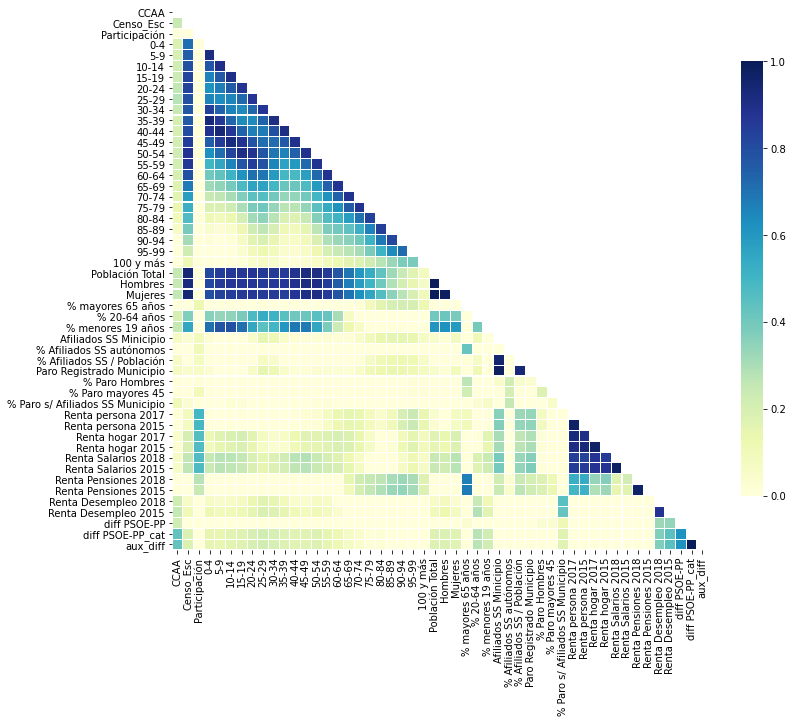

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

...que como en otros casos muestra una correlación muy fuerte entre rentas entre sí, por ejemplo, así como la de CCAA con la objetivo.

In [ ]:
df_train.columns

Index(['CCAA', 'Censo_Esc', 'Participación', '0-4', '5-9', '10-14', '15-19',
       '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
       '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99',
       '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'diff PSOE-PP', 'diff PSOE-PP_cat', 'aux_diff'],
      dtype='object')

Eliminamos algunas columnas demasiado correlacionadas.

In [ ]:
df_train = df_train.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_train = df_train.drop(['diff PSOE-PP', 'aux_diff'], axis = 1)

In [ ]:
df_train

,CCAA,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018,diff PSOE-PP_cat
0,1.334694,790,0.768354,42,50,39,48,42,56,48,82,83,83,73,62,56,56,86,43,40,33,12,3,0,1037,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,24932.0,6997.000000,3853.000000,325.000000,3
1,1.918950,1237,0.709782,42,45,83,115,101,69,85,45,84,128,154,114,112,60,51,37,48,66,43,17,3,1502,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,38245.0,11471.000000,2131.000000,243.000000,2
2,1.717405,251,0.868526,5,5,7,9,4,7,19,23,18,16,19,33,19,20,16,17,18,17,9,1,0,282,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,23170.0,9044.000000,3908.000000,176.000000,2
3,2.514286,1011,0.785361,60,58,54,53,77,90,91,83,76,67,101,101,73,51,60,56,38,34,9,5,0,1237,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,17583.0,3733.000000,1957.000000,719.000000,4
4,2.526272,758,0.716359,54,54,58,50,40,67,54,78,64,64,84,63,47,41,32,36,26,30,8,1,0,951,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,19859.0,5392.000000,2168.000000,616.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,2.684965,560,0.694643,40,44,55,40,63,54,69,83,69,38,63,72,61,54,30,16,27,19,16,7,0,920,0.183696,0.621739,0.194565,6412.0,0.209607,6.969565,1228.0,0.383550,0.506515,0.160733,10904.0,27543.0,7230.000000,3238.000000,269.000000,1
29049,0.887975,561,0.814617,36,58,52,52,39,48,29,56,72,79,61,32,25,43,23,19,17,9,0,0,0,750,0.148000,0.588000,0.264000,220555.0,0.135699,294.073333,40847.0,0.402184,0.479448,0.156261,9491.0,26916.0,7627.000000,2071.000000,227.000000,1
29050,2.064029,513,0.807018,17,11,13,19,25,20,24,34,34,49,47,43,42,33,55,46,24,30,14,3,0,583,0.351630,0.545455,0.102916,12349.0,0.196696,21.181818,5768.0,0.445735,0.480583,0.318375,16267.0,35715.0,8283.665447,3176.861782,289.773974,1
29051,2.684965,1041,0.669549,134,118,124,75,108,106,123,188,182,136,121,100,106,94,72,58,48,27,10,6,1,1937,0.163139,0.604027,0.232834,14852.0,0.151697,7.667527,2746.0,0.483248,0.520393,0.156040,8499.0,24419.0,5903.000000,2392.000000,318.000000,3


Nos quedamos solo con los registros que contienen valores en la columna objetivo, casi todos por otra parte.

In [ ]:
df_train = df_train[df_train['diff PSOE-PP_cat'].notnull()]

In [ ]:
df_train.describe()

,CCAA,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018,diff PSOE-PP_cat
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.905300e+04,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000
mean,1.943276,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,29414.936055,8283.665447,3176.861782,289.773974,1.943276
std,0.589517,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,0.095884,0.054285,0.060523,5.160863e+05,0.157919,444.827822,55876.090363,0.091613,0.096981,0.103336,3628.107342,10023.258516,3431.089234,1357.859980,115.577207,1.379599
min,0.705495,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,12087.000000,1767.000000,345.000000,71.000000,0.000000
25%,1.717405,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,0.159597,0.572816,0.143734,1.846000e+03,0.121701,1.325815,574.000000,0.398112,0.488397,0.138930,9099.000000,23213.000000,6082.000000,2265.000000,220.000000,1.000000
50%,1.918950,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,0.211869,0.605886,0.176874,1.434400e+04,0.179083,9.850248,4240.000000,0.421271,0.525926,0.192784,10924.000000,27618.000000,7855.336603,3110.000000,277.000000,2.000000
75%,2.526272,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,0.272635,0.633694,0.212171,9.949500e+04,0.280792,81.265306,22481.000000,0.442646,0.547041,0.274113,12919.000000,32791.000000,9546.000000,3800.000000,322.000000,3.000000
max,2.684965,3480.000000,1.000000,650.000000,560.000000,468.000000,365.000000,362.000000,491.000000,647.000000,854.000000,918.000000,704.000000,718.000000,957.000000,1256.000000,1740.000000,2105.000000,1262.000000,591.000000,193.000000,145.000000,51.000000,20.000000,11747.000000,0.857143,1.000000,0.458289,1.996269e+06,1.000000,3355.073950,220332.000000,1.000000,1.000000,0.777778,30210.000000,86006.000000,26674.000000,8302.000000,846.000000,4.000000


Ahora ya podemos definir para el dataset train tanto el vector 'y' como la matriz X.

In [ ]:
y_train = df_train['diff PSOE-PP_cat']

In [ ]:
y_train

0        3
1        2
2        2
3        4
4        3
        ..
29048    1
29049    1
29050    1
29051    3
29052    3
Name: diff PSOE-PP_cat, Length: 29053, dtype: object

In [ ]:
X_train = df_train.drop(['diff PSOE-PP_cat'], axis = 1)

In [ ]:
X_train.shape

(29053, 40)

In [ ]:
y_train.shape

(29053,)

##Dataset de Test

Pasamos ahora al dataset Test, al que aplicaremos los mismos procesos que al train y en el mismo orden.

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/test_set_RF_dif_PP_PSOE.txt',  dtype = strings)

In [ ]:
df_test

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,diff PSOE-PP,diff PSOE-PP_cat
0,022019041082408910003,08,24,24089,2408910003,Castilla - La Mancha,León,León,638,480,0.752351,8,472,4,468,105,151,82,61,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,9,...,71,55,55,66,41,38,45,25,52,38,17,5,0,783,335,448,0.280971,0.556833,0.162197,63898.0,0.128439,81.606641,11285.0,0.429154,0.528135,0.150100,11009.0,10229.0,23550.0,21824.0,6997.0,5837.0,4398.0,4420.0,177.0,253.0,"{'PP': 105, 'PSOE': 151, 'Cs': 82, 'UP': 61, '...","[('PSOE', 151), ('PP', 105), ('Cs', 82), ('UP'...",0.097458,2
1,022019041084718603004,08,47,47186,4718603004,Castilla - La Mancha,Valladolid,Valladolid,736,597,0.811141,0,597,9,588,130,159,131,81,0,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,...,76,90,75,61,65,39,42,43,38,19,17,4,0,911,394,517,0.221734,0.615807,0.162459,146297.0,0.113782,160.589462,24645.0,0.426375,0.532684,0.144172,12114.0,11259.0,27930.0,27039.0,9269.0,7373.0,3657.0,3545.0,207.0,197.0,"{'PP': 130, 'PSOE': 159, 'Cs': 131, 'UP': 81, ...","[('PSOE', 159), ('Cs', 131), ('PP', 130), ('UP...",0.048576,1
2,022019041053800601012,05,38,38006,3800601012,Canarias,Santa Cruz de Tenerife,Arona,875,504,0.576000,7,497,3,494,79,173,61,50,0,29,0,0,0,0,0,0,0,0,0,0,87,0,0,0,0,0,0,6,9,...,101,120,89,89,88,60,38,25,12,12,2,2,0,1282,639,643,0.117785,0.665367,0.216849,30637.0,0.185625,23.897816,8767.0,0.445991,0.514999,0.222490,7499.0,6930.0,22157.0,20318.0,5828.0,4892.0,1629.0,1396.0,447.0,574.0,"{'PP': 79, 'PSOE': 173, 'Cs': 61, 'UP': 50, 'I...","[('PSOE', 173), ('CC', 87), ('PP', 79), ('Cs',...",0.189135,3
3,022019041090801905042,09,08,08019,801905042,Cataluña,Barcelona,Barcelona,931,779,0.836735,0,779,9,770,80,135,163,51,0,50,0,0,0,148,121,0,0,0,0,0,0,0,0,0,0,0,0,7,15,...,88,67,94,81,76,56,56,53,52,41,22,6,1,1297,615,682,0.221280,0.596762,0.181958,1134047.0,0.108401,874.361604,87744.0,0.458413,0.535843,0.071816,21924.0,20374.0,51413.0,47815.0,15592.0,13968.0,4605.0,4711.0,146.0,203.0,"{'PP': 80, 'PSOE': 135, 'Cs': 163, 'UP': 51, '...","[('Cs', 163), ('ERC', 148), ('PSOE', 135), ('J...",0.070603,1
4,022019041010407902002,01,04,04079,407902002,Andalucía,Almería,Roquetas de Mar,1289,884,0.685803,3,881,11,870,210,225,135,82,0,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,9,...,222,188,148,122,100,71,65,31,24,9,5,2,0,2265,1196,1069,0.091391,0.657837,0.250773,29256.0,0.262955,12.916556,10769.0,0.436345,0.452410,0.269057,7199.0,6616.0,21454.0,19992.0,4799.0,3931.0,963.0,975.0,468.0,540.0,"{'PP': 210, 'PSOE': 225, 'Cs': 135, 'UP': 82, ...","[('PSOE', 225), ('PP', 210), ('VOX', 202), ('C...",0.017026,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,022019041122807901087,12,28,28079,2807901087,Galicia,Madrid,Madrid,934,804,0.860814,4,800,4,796,229,177,200,69,0,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,...,108,94,127,84,70,46,51,38,25,25,15,3,1,1324,625,699,0.154079,0.700906,0.145015,1996269.0,0.096084,1507.756042,220332.0,0.442646,0.534126,0.099401,28839.0,28350.0,65532.0,63739

In [ ]:
df_test['diff PSOE-PP_cat'].value_counts()

2    1780
0    1626
3    1441
1    1245
4    1172
Name: diff PSOE-PP_cat, dtype: int64

Seleccionamos las columnas válidas...

In [ ]:
df_test = df_test[cols_validas]

...rellenamos los registros nan...

In [ ]:
for item in FillNA_num_mean:
        
    df_test[item].fillna(df_test[item].mean(), inplace=True)

In [ ]:
df_test.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP,diff PSOE-PP_cat
count,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7.264000e+03,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000
mean,964.510463,0.761238,56.757847,65.368117,68.839482,64.242704,63.665611,70.971503,79.435986,97.142346,111.609306,105.841272,100.765006,90.304653,77.011426,65.940116,60.085215,44.601184,37.297081,27.047081,11.468475,2.869080,0.442869,1301.706360,637.887665,663.818695,0.221985,0.600487,0.177528,2.225054e+05,0.229574,178.121430,28542.727999,0.427643,0.528740,0.209475,11599.281185,10953.304803,29727.261056,28232.783478,8435.265551,7422.618868,3184.472424,2948.730812,288.400877,345.239563,0.099572,1.901982
std,438.429341,0.072187,46.486400,50.355804,49.578011,42.145355,37.483447,42.143865,51.700767,68.389342,75.888578,66.019778,55.810565,46.720593,40.735139,37.391622,35.569481,25.962204,20.704981,16.239465,8.272174,2.864042,0.820894,651.462011,326.329489,329.036556,0.095981,0.053882,0.060227,5.298457e+05,0.154879,453.929190,57136.914978,0.090545,0.097431,0.102826,3700.887721,3592.163777,10265.472868,9881.109672,3586.070072,3391.461365,1353.331309,1212.689717,117.682122,116.071477,0.162221,1.378830
min,6.000000,0.273438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,3.000000,2.000000,0.007463,0.200000,0.000000,2.000000e+00,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-0.750000,0.000000
25%,694.000000,0.722909,29.000000,33.000000,36.000000,36.000000,39.000000,45.000000,48.000000,56.000000,63.000000,63.000000,64.000000,60.000000,51.000000,43.000000,39.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,908.750000,434.000000,468.000000,0.158919,0.572505,0.143781,2.001000e+03,0.121375,1.409837,600.750000,0.397611,0.490343,0.137186,9144.000000,8537.750000,23393.500000,22021.500000,6088.500000,5177.250000,2283.750000,2134.000000,216.000000,276.000000,0.015463,1.000000
50%,955.000000,0.767973,48.000000,55.000000,59.000000,57.000000,60.000000,68.000000,73.000000,86.000000,98.000000,95.000000,95.000000,87.000000,74.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1260.000000,610.500000,651.000000,0.212198,0.605347,0.177567,1.382200e+04,0.179083,9.783425,4147.000000,0.420875,0.527070,0.192784,10985.000000,10363.500000,27625.000000,26131.500000,7855.336603,6845.948425,3124.500000,2916.000000,273.000000,339.000000,0.114376,2.000000
75%,1251.250000,0.810201,74.000000,86.000000,92.000000,88.000000,85.000000,94.000000,104.000000,125.000000,144.000000,139.000000,132.000000,117.000000,100.000000,86.000000,78.000000,59.000000,50.000000,37.000000,16.000000,4.000000,1.000000,1691.000000,827.000000,865.000000,0.272616,0.633610,0.212706,1.008638e+05

In [ ]:
df_test.dtypes

CCAA                                 object
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

...llevamos a cabo el mapeo de la columna categórica, CCAA...

In [ ]:
for c in categorical:
    df_test[c] = df_test[c].map(mean_map1[c])

In [ ]:
df_test.dtypes

CCAA                                float64
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

In [ ]:
df_test['CCAA'].describe()

count    7264.000000
mean        1.935819
std         0.592536
min         0.705495
25%         1.717405
50%         1.918950
75%         2.526272
max         2.684965
Name: CCAA, dtype: float64

...quitamos las columnas demasiado correlacionadas...

In [ ]:
df_test = df_test.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_test = df_test.drop(['diff PSOE-PP'], axis = 1)

In [ ]:
df_test.shape

(7264, 41)

...y nos quedamos con las filas que tienen valores en la variable objetivo.

In [ ]:
df_test = df_test[df_test['diff PSOE-PP_cat'].notnull()]

Con todo ello ya podemos definir el vector 'y' y la matriz X del dataset de test.

In [ ]:
y_test = df_test['diff PSOE-PP_cat']

In [ ]:
X_test = df_test.drop(['diff PSOE-PP_cat'], axis = 1)

In [ ]:
y_test.shape

(7264,)

In [ ]:
X_test.shape

(7264, 40)

In [ ]:
columnas = X_train.columns

Pasamos los vectores y matrices a numpy arrays. El error se produce al intentar aplicar por error el método .values una segunda vez.

In [ ]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

AttributeError: ignored

##Relevancia de las columnas

Ahora intentamos ver qué columnas son las que aportan una mayor información, mediante los procedimientos F-Test y Mutual Info.

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
y_train

array([3, 2, 2, ..., 1, 3, 3])

In [ ]:
y_test

array([2, 1, 3, ..., 2, 3, 3])

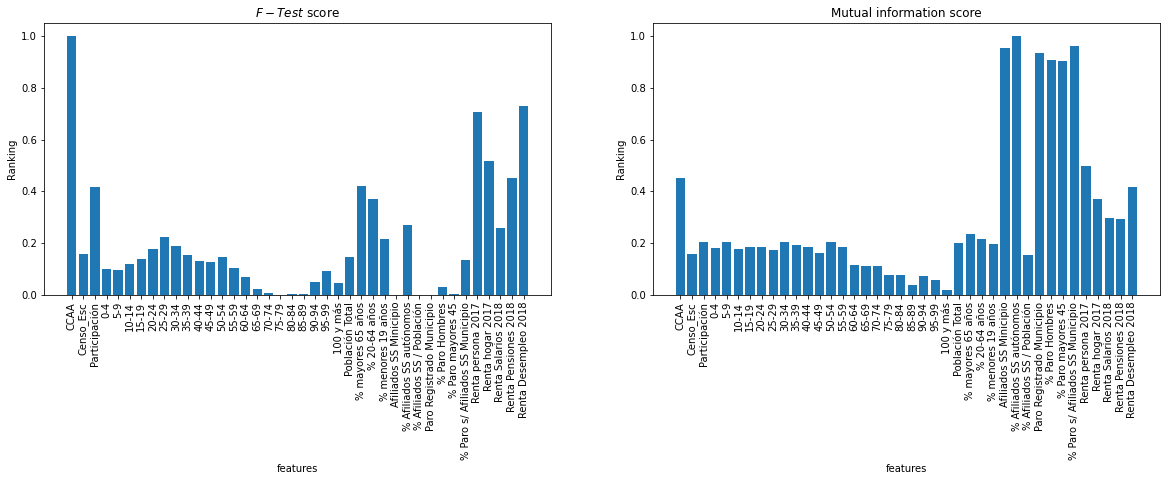

In [ ]:
y = y_train    # nos quedamos con la 1ª columna, price
X = X_train      # nos quedamos con el resto

feature_names = columnas


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Vemos que en MI, las columnas más importantes son las relacionadas con el paro y la afiliación, y algo menos la CCAA.

Seleccionamos, por si hiciese falta, las columnas con un mayor coeficiente relativo MI, que resultan ser 12.

In [ ]:
columnas_MI = columnas[mi > 0.25]

In [ ]:
columnas_MI

Index(['CCAA', 'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       'Paro Registrado Municipio', '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta hogar 2017', 'Renta Salarios 2018', 'Renta Pensiones 2018',
       'Renta Desempleo 2018'],
      dtype='object')

In [ ]:
len(columnas_MI)

12

In [ ]:
X_train

array([[1.33469388e+00, 7.90000000e+02, 7.68354430e-01, ...,
        6.99700000e+03, 3.85300000e+03, 3.25000000e+02],
       [1.91894977e+00, 1.23700000e+03, 7.09781730e-01, ...,
        1.14710000e+04, 2.13100000e+03, 2.43000000e+02],
       [1.71740527e+00, 2.51000000e+02, 8.68525896e-01, ...,
        9.04400000e+03, 3.90800000e+03, 1.76000000e+02],
       ...,
       [2.06402878e+00, 5.13000000e+02, 8.07017544e-01, ...,
        8.28366545e+03, 3.17686178e+03, 2.89773974e+02],
       [2.68496538e+00, 1.04100000e+03, 6.69548511e-01, ...,
        5.90300000e+03, 2.39200000e+03, 3.18000000e+02],
       [2.52627207e+00, 1.25100000e+03, 6.37090328e-01, ...,
        6.01200000e+03, 2.03300000e+03, 5.03000000e+02]])

In [ ]:
y_train

array([3, 2, 2, ..., 1, 3, 3])

##Modelización con random forest clasificación

Ahora ya podemos empezar a modelizar con Random Forest Classifier, pues estamos en clasificación.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Utilizamos grid search con la profundidad, y vemos que no alcanzamos el máximo con 15, aunque el crecimiento se va ralentizando.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

best mean cross-validation score: 0.527
best parameters: {'max_depth': 14}


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   26.3s finished


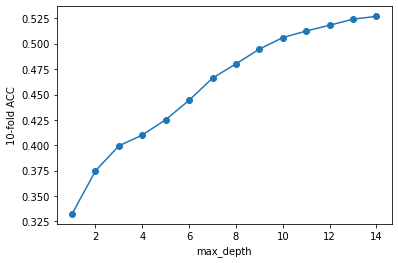

In [ ]:

# grid search
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt', verbose = 1), 
                    param_grid=tuned_parameters,cv=5) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Lo intentamos ahora yendo hasta profundidades de 20... y sigue la misma tendencia...

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   18.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

best mean cross-validation score: 0.533
best parameters: {'max_depth': 18}


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   30.4s finished


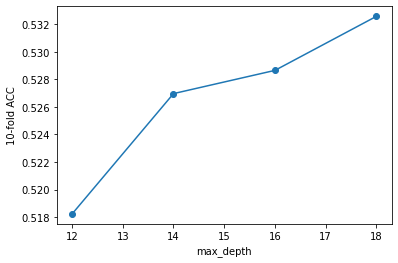

In [ ]:
maxDepth = range(12,20,2)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt', verbose = 1), 
                    param_grid=tuned_parameters,cv=5) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

...y por puro masoquismo subimos hasta 40, donde el mean test score apenas se mueve.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   25.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

best mean cross-validation score: 0.534
best parameters: {'max_depth': 40}


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   33.5s finished


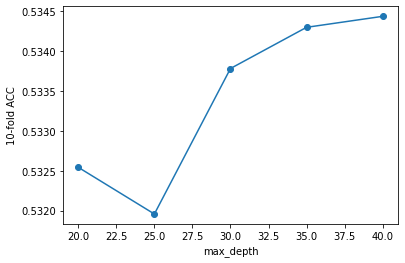

In [ ]:
maxDepth = range(20,45,5)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt', verbose = 1), 
                    param_grid=tuned_parameters,cv=5) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Hacemos el fit con profundidad 40, y, como cabía esperar, tenemos un overfitting de caballo.

In [ ]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestClassifier(max_depth=maxDepthOptimo, n_estimators=200, max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  1.0
Test:  0.5468061674008811


In [ ]:
bagModel.feature_importances_

array([0.05418136, 0.01999583, 0.0296191 , 0.01919127, 0.02054574,
       0.02110202, 0.01993416, 0.01956618, 0.01980322, 0.02063036,
       0.02149978, 0.0217591 , 0.02060836, 0.02025581, 0.01998175,
       0.02094439, 0.0208849 , 0.02059291, 0.02016083, 0.02003315,
       0.02056494, 0.01976852, 0.01379873, 0.00581933, 0.01848012,
       0.02871247, 0.0306229 , 0.02455292, 0.02486601, 0.02777979,
       0.02863712, 0.02676375, 0.02653333, 0.02588246, 0.02678609,
       0.05505751, 0.04323816, 0.03489955, 0.0296276 , 0.03631847])

Tendremos que reducir la profundidas, es claro, pero podemos aprovechar para bajar también la dimensionalidad. Para ello consultamos la importancia de las columnas, que random forest calcula. 

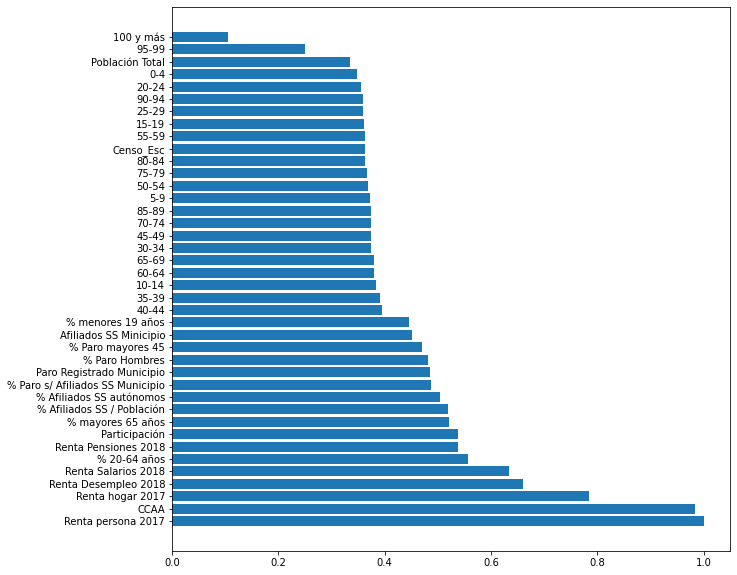

In [ ]:
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),columnas[indices])
plt.show()

Podemos seleccionar las que tienen, en términos relativos, una importancia superior a 0,5; vemos que las más importantes son la renta y la propia CCAA, como cabía esperar. Ahora tendremos solo 11 columnas.

In [ ]:
cols_import = columnas[importances > 0.5]

In [ ]:
cols_import

Index(['CCAA', 'Participación', '% mayores 65 años', '% 20-64 años',
       '% Afiliados SS autónomos', '% Afiliados SS / Población',
       'Renta persona 2017', 'Renta hogar 2017', 'Renta Salarios 2018',
       'Renta Pensiones 2018', 'Renta Desempleo 2018'],
      dtype='object')

In [ ]:
len(cols_import)

11

Preparamos las matrices X de train y de test.

In [ ]:
X_train = df_train[cols_import]

In [ ]:
X_train = X_train.values

In [ ]:
X_train.shape

(29053, 11)

In [ ]:
X_test = df_test[cols_import]

In [ ]:
X_test.shape

(7264, 11)

In [ ]:
X_test = X_test.values

Volvemos a aplicar el grid search con la profundidad, y de nuevo el máximo se alcanzaría en 15.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

best mean cross-validation score: 0.519
best parameters: {'max_depth': 15}


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   18.7s finished


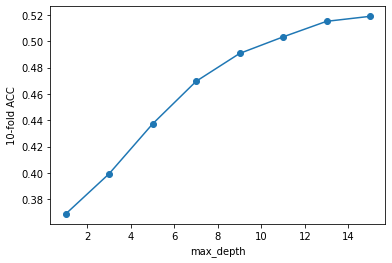

In [ ]:
maxDepth = range(1,17,2)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt', verbose = 1), 
                    param_grid=tuned_parameters,cv=5) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Pero esta vez, basados en la experiencia, tomamos una profundidad inferior, de 8, que al menos elimina el overfitting. Teniendo en cuenta que tenemos una clasificación de cinco posibles valores nivelados entre sí, con lo que el accuracy aleatrio sería del 0.2, el obtener un 0.5 pensamos que puede ser aceptable.

In [ ]:
# maxDepthOptimo = grid.best_params_['max_depth']
maxDepthOptimo = 8
bagModel = RandomForestClassifier(max_depth=maxDepthOptimo, n_estimators=200, max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.5250404433277114
Test:  0.48499449339207046
